# **High-Frequency Quasi-Periodic Oscillations in the Solar Corona Observed with High-Frame-Rate Imaging During the 2023 Total Solar Eclipse**
### **Data Processing and Analysis Notebook**

**Authors**: [Yu Liang]
**Affiliation**: [Shanghai Astronomical Observatory, Chinese Academy of Sciences, Shanghai 200030, China]  
**Contact**: [yuliang@shao.ac.cn]  
**Last Updated**: [2024-12-10]  

---

### **Notebook Overview**

These Jupyter Notebook documents the processing and analysis of observational data collected during the 2023 total solar eclipse. The primary objectives of this Notebook include:

1. Preprocessing of raw white-light corona imaging data (dark field subtraction, flat field correction, and temporal registration).
2. Application of wavelet analysis to detect high-frequency quasi-periodic oscillations (HFQPOs).
3. Visualizations of the solar corona and statistical results for Sun-as-a-star analysis.

---

### **Dependencies**

The analysis relies on the following Python libraries (compatible versions):  
- `numpy==1.2.43`  
- `pandas==1.5.1`  
- `scikit-image==0.20.0`  
- `matplotlib==3.7.1`  
- `astropy==5.1.1`  
- `opencv-python==4.7.0.72`  
- `Pillow==9.2.0`  
- `scipy==1.13.1`  


<!-- A complete list of dependencies can be found in the accompanying `requirements.txt`. -->

---

### **Data Source**

- **Observation Site**: Learmonth Airport, Australia  
- **Instrument**: iPhone with 565 nm filter, sampling at 240 fps, frams width * height: 720.0 * 1280.0, image shape:(1280, 720, 3)  
- **Date**: April 20, 2023  

---

### **Main Structure**

- **Section 1**: Data loading and inspection  
- **Section 2**: Preprocessing (dark field, flat field, and registration)  
- **Section 3**: Wavelet analysis and signal detection  
- **Section 4**: Results visualization and discussion  

---
### **Notebook 5.1**
#### divide R slicers. 
- input: *.fits
- output: *.npy

STEP 1: file load. 

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import os
import numpy as np
from astropy.io import fits
import skimage.io as io 
import imageio as iio
from skimage import data
from skimage.registration import phase_cross_correlation
from skimage.registration._phase_cross_correlation import _upsampled_dft
from scipy.ndimage import fourier_shift
from PIL import Image
import glob

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


In [2]:
path0 = '/Volumes/WD1T/share/TSE2023/'                  # input dir
path1 = '/Volumes/WD1T/share/TSE2023/iPhone/result/'    # input dir
pathpol  = path1 + 'pol_rot_r2dfdata/'                  # pahtfd = path with flat and dark processed

outputpath = './output/'


In [3]:
# delete ._* files
files_to_delete = glob.glob(os.path.join(pathpol, '._*'))

for file in files_to_delete:
    try:
        os.remove(file)
        print(f"Deleted: {file}")
    except Exception as e:
        print(f"Error deleting {file}: {e}")

In [4]:
# preview
pathd = pathpol
listd = os.listdir(pathd)
listd.sort()
print(listd[0:10])
print(len(listd))
st = 0
fn = len(listd) - st

['pol_rot_r2_r1_image_00000.fits', 'pol_rot_r2_r1_image_00001.fits', 'pol_rot_r2_r1_image_00002.fits', 'pol_rot_r2_r1_image_00003.fits', 'pol_rot_r2_r1_image_00004.fits', 'pol_rot_r2_r1_image_00005.fits', 'pol_rot_r2_r1_image_00006.fits', 'pol_rot_r2_r1_image_00007.fits', 'pol_rot_r2_r1_image_00008.fits', 'pol_rot_r2_r1_image_00009.fits']
13301


155 360


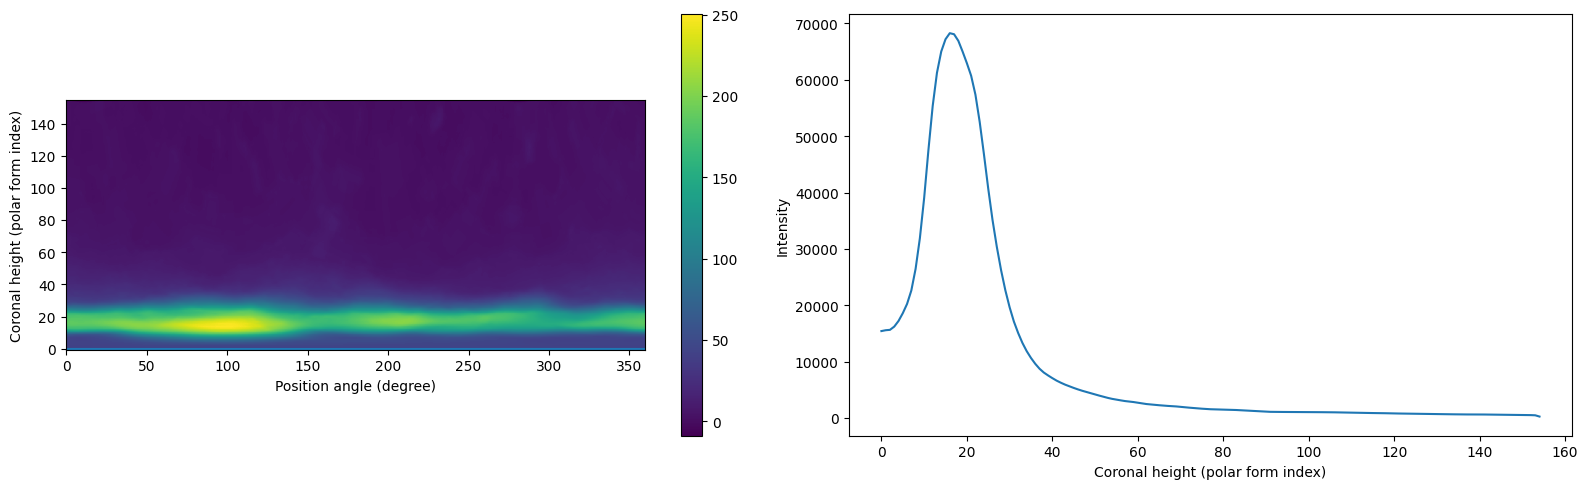

In [5]:
hdu = fits.open(pathd + listd[st + 13000])
img = hdu[0].data
pimg = img 
m,n = pimg.shape
print(m,n)
rp = np.sum(pimg,axis=1)
ridx = np.argmax(rp[0:100])

plt.figure(figsize=[16,5])
plt.subplot(121)
plt.imshow(img,origin='lower')
plt.xlabel('Position angle (degree)')
plt.ylabel('Coronal height (polar form index)')
# plt.axhline(y=138, color='r', linestyle='--', linewidth=2)
# plt.axhline(y=153, color='r', linestyle='--', linewidth=2)
plt.axhline()
plt.colorbar()
plt.subplot(122)
plt.plot(rp)             # between 1.006 and 4.5 R_sun
plt.xlabel('Coronal height (polar form index)')
plt.ylabel('Intensity')
plt.tight_layout()
plt.show()

---
### **Notebook 5.1**
#### divide R slicers. 
- input: *.fits
- output: *.npy

STEP 2: Define the slicer pixel index and divide the radial slicers.

- The value for each slicer is defined as the average value of the corresponding pixel region.
- The file `mrdata.npy` stores the slicer values for each frame.
- The shape of `mrdata.npy` is defined as: `[number of slicers, number of frames]`.

In [6]:
from astropy.io import fits

# Constants and initial setup
OCCLUSION_RATE = 1.0066
#COORDINATES = (114.0944, -22.2395)

# Helper function to calculate radii
def calculate_radii(base_radius, factors):
    return [int(base_radius / OCCLUSION_RATE * factor) for factor in factors]

# Pre-defined radii multipliers
MULTIPLIERS = np.arange(1.1, 9.1, 0.1)

# Initialize arrays
# sr = 10
fn = len(listd)  # Assuming listd is defined
dataset_shape = (len(MULTIPLIERS), fn)  # Include extra space for the 0th index
mdata = np.zeros(dataset_shape, dtype='float32')
ridxs = np.zeros(fn)

# Dynamically determine the size of rps based on the first FITS file
example_hdu = fits.open(pathd + listd[0])  # Open the first file as an example
example_img = example_hdu[0].data
n = example_img.shape[0]  # Use the row count of the example image
rps = np.zeros((fn, n))  # Initialize rps with correct size
example_hdu.close()

# Process frames
for i, filename in enumerate(listd[st:st + fn]):
    hdu = fits.open(pathd + filename)
    print(f'Frame {i}, {filename} loaded.')

    img = hdu[0].data
    rp = np.sum(img, axis=1)  # Radial peak
    ridx = np.argmax(rp[0:100])
    ridxs[i] = ridx
    rps[i, :len(rp)] = rp  # Only fill the portion of rps that matches rp


# Calculate base radius and radii after processing all frames
base_radius = int(np.mean(ridxs))
print('the mean value of the R max index is:', base_radius)
radii = calculate_radii(base_radius, MULTIPLIERS)

# Print selected radii for verification
print(radii)
# Print selected radii for verification
print(*[radii[i] for i in [0, 1, 2, 3, 4, 9, 14, 19, 20, 21, 22, 23]])

# Calculate mean values in concentric radii
for i in range(fn):
    img = fits.open(pathd + listd[st + i])[0].data  # Reload image if needed
    ridx = int(ridxs[i])

    for j, radius in enumerate(radii):
        start_idx = ridx if j == 0 else radii[j - 1]
        end_idx = None if j == len(radii) - 1 else radius

        mean_value = np.mean(img[start_idx:end_idx, :])
        mdata[j, i] = mean_value

    mean_value = np.mean(img[int(base_radius * 1.006):int(base_radius * 1.1), :])
    mdata[0, i] = mean_value

# Save the result
np.save('./output/mrdata.npy', mdata)

Frame 0, pol_rot_r2_r1_image_00000.fits loaded.
Frame 1, pol_rot_r2_r1_image_00001.fits loaded.
Frame 2, pol_rot_r2_r1_image_00002.fits loaded.
Frame 3, pol_rot_r2_r1_image_00003.fits loaded.
Frame 4, pol_rot_r2_r1_image_00004.fits loaded.
Frame 5, pol_rot_r2_r1_image_00005.fits loaded.
Frame 6, pol_rot_r2_r1_image_00006.fits loaded.
Frame 7, pol_rot_r2_r1_image_00007.fits loaded.
Frame 8, pol_rot_r2_r1_image_00008.fits loaded.
Frame 9, pol_rot_r2_r1_image_00009.fits loaded.
Frame 10, pol_rot_r2_r1_image_00010.fits loaded.
Frame 11, pol_rot_r2_r1_image_00011.fits loaded.
Frame 12, pol_rot_r2_r1_image_00012.fits loaded.
Frame 13, pol_rot_r2_r1_image_00013.fits loaded.
Frame 14, pol_rot_r2_r1_image_00014.fits loaded.
Frame 15, pol_rot_r2_r1_image_00015.fits loaded.
Frame 16, pol_rot_r2_r1_image_00016.fits loaded.
Frame 17, pol_rot_r2_r1_image_00017.fits loaded.
Frame 18, pol_rot_r2_r1_image_00018.fits loaded.
Frame 19, pol_rot_r2_r1_image_00019.fits loaded.
Frame 20, pol_rot_r2_r1_image_

/opt/anaconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in divide
  ret = ret.dtype.type(ret / rcount)


In [7]:
# Print selected radii for verification
print(radii)
# Print selected radii for verification
print(*[radii[i] for i in [0, 1, 2, 3, 4, 9, 14, 19, 20, 21, 22, 23]])

[17, 19, 20, 22, 23, 25, 27, 28, 30, 31, 33, 34, 36, 38, 39, 41, 42, 44, 46, 47, 49, 50, 52, 54, 55, 57, 58, 60, 61, 63, 65, 66, 68, 69, 71, 73, 74, 76, 77, 79, 81, 82, 84, 85, 87, 89, 90, 92, 93, 95, 96, 98, 100, 101, 103, 104, 106, 108, 109, 111, 112, 114, 116, 117, 119, 120, 122, 123, 125, 127, 128, 130, 131, 133, 135, 136, 138, 139, 141, 143]
17 19 20 22 23 31 39 47 49 50 52 54


In [8]:
MULTIPLIERS = np.arange(1.1, 9.1, 0.1)
MULTIPLIERS.shape,MULTIPLIERS, mdata.shape

((80,),
 array([1.1, 1.2, 1.3, 1.4, 1.5, 1.6, 1.7, 1.8, 1.9, 2. , 2.1, 2.2, 2.3,
        2.4, 2.5, 2.6, 2.7, 2.8, 2.9, 3. , 3.1, 3.2, 3.3, 3.4, 3.5, 3.6,
        3.7, 3.8, 3.9, 4. , 4.1, 4.2, 4.3, 4.4, 4.5, 4.6, 4.7, 4.8, 4.9,
        5. , 5.1, 5.2, 5.3, 5.4, 5.5, 5.6, 5.7, 5.8, 5.9, 6. , 6.1, 6.2,
        6.3, 6.4, 6.5, 6.6, 6.7, 6.8, 6.9, 7. , 7.1, 7.2, 7.3, 7.4, 7.5,
        7.6, 7.7, 7.8, 7.9, 8. , 8.1, 8.2, 8.3, 8.4, 8.5, 8.6, 8.7, 8.8,
        8.9, 9. ]),
 (80, 13301))

In [9]:
mdata.shape

(80, 13301)

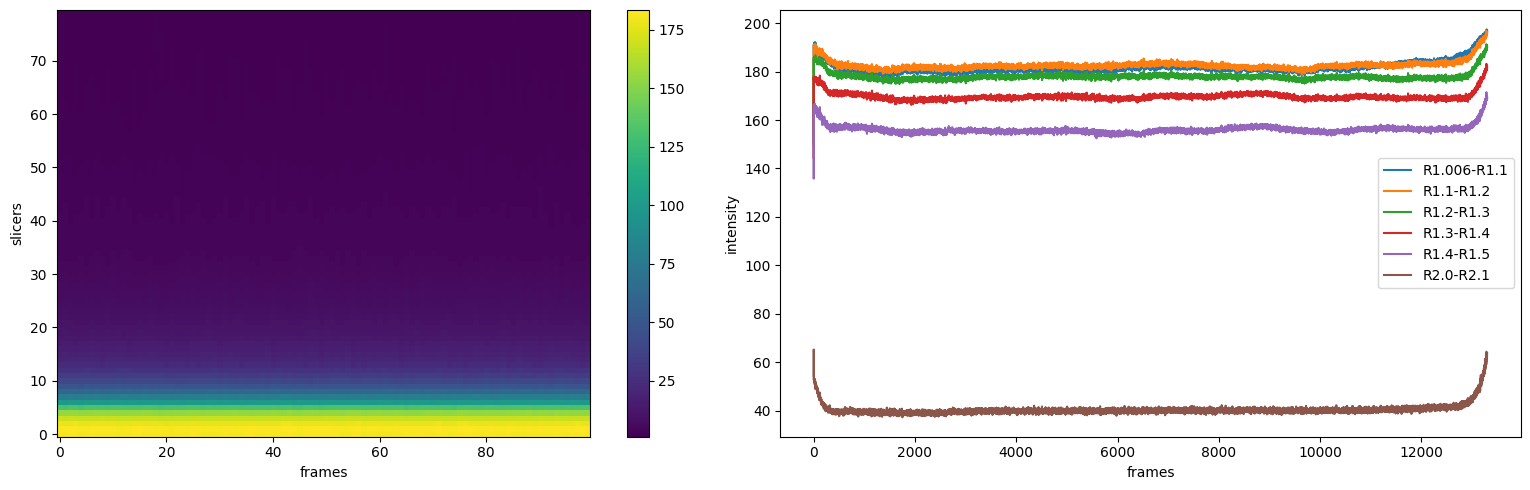

In [10]:
plt.figure(figsize = [16,5])
plt.subplot(121)
plt.imshow(mdata[:,6000:6100],origin='lower')
plt.xlabel('frames')
plt.ylabel('slicers')
plt.colorbar()
plt.subplot(122)
plt.plot(mdata[0],label='R1.006-R1.1')
plt.plot(mdata[1],label='R1.1-R1.2')
plt.plot(mdata[2],label='R1.2-R1.3')
plt.plot(mdata[3],label='R1.3-R1.4')
plt.plot(mdata[4],label='R1.4-R1.5')
plt.plot(mdata[10],label='R2.0-R2.1')
plt.legend()
plt.xlabel('frames')
plt.ylabel('intensity')
plt.tight_layout()
plt.show()


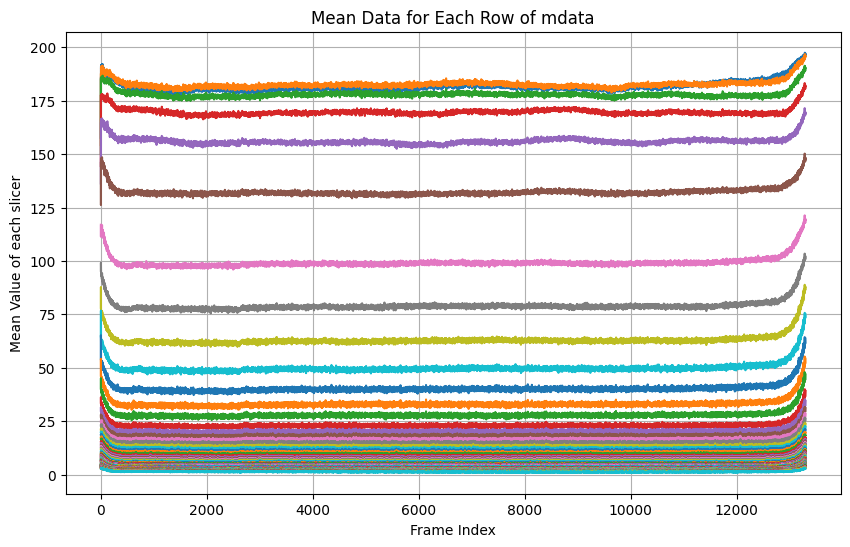

In [11]:
# Plot each row of mdata on the same graph
plt.figure(figsize=(10, 6))
for i in range(mdata.shape[0]):
    plt.plot(mdata[i, :], label=f'Row {i}')

plt.title('Mean Data for Each Row of mdata')
plt.xlabel('Frame Index')
plt.ylabel('Mean Value of each slicer')
#plt.legend()
plt.grid()
plt.show()